<h1> Processo Explicativo <h1/>

Neste processo explicativo estarei importando bibliotecas de acordo com o uso, se quiser o código completo, vá para: [codigo](codigo-fonte-widget-image)

O aplicativo estará dividido em dois arquivos, um .py para a lógica e um .kv para a interface <br> Começaremos pelo .py (python)

<h2> Importando as bibliotecas essenciais <h2/>

In [ ]:
import cv2 #OpenCV para manipulação da imagem
from kivy.app import App #Classe base para a criação de aplicativos no Kivy

<h2> Integração da interface com a lógica: <h2\>

Screen Manager: gerenciamento das telas que serão declaradas no arquivo .kv

In [ ]:
from kivy.uix.screenmanager import ScreenManager, Screen

#criação das classes para cada tela

class MainScreen(Screen):    #aqui criamos a classe no .py da tela inicial do app, onde vai abrir a câmera
    pass

class ScreenAfterButton(Screen):     #também criamos a classe da tela que aparecerá após a fotografia
    pass

#não precisamos criar uma classe para o manager pois estaremos já chamando a função no build do app

Aviso: O nome das classes das telas deve ser o mesmo do que será declarado para as telas no .kv

Builder: permite o carregamento do arquivo .kv que conterá as especificações de widgets das telas

In [ ]:
from kivy.lang import Builder

Builder.load_file("screen.kv") #carrega o arquivo da interface

<h2> Lógica do App <h2/>

<h4> Classe do App <br> Função build <h4/>

Chamando a função ScreenManager e adicionando as telas para ela

In [ ]:
class Main(App):
    def build(self):
        sm = ScreenManager() #chamo a função ScreenManager()
        self.main_screen = MainScreen(name="main") #atribuo a tela principal para poder chamá-la depois (adicionar o video da câmera)
        self.screen_after = ScreenAfterButton(name="after") #atribuo a tela secundária para poder chamar depois (atualizar a textura após a captura da imagem)
        sm.add_widget(self.main_screen) #adiciono a tela principal ao manager
        sm.add_widget(self.screen_after) #adiciono a tela secundária ao manager

Adicionando o widget que terá o video da câmera à tela principal

In [ ]:
from kivy.uix.image import Image #classe para o carregamento da imagem na tela
from kivy.core.window import Window #classe que usaremos para dimensionar imagens e objetos à tela

class Main(App):
    def build(self):
        sm = ScreenManager()
        self.main_screen = MainScreen(name="main")
        self.screen_after = ScreenAfterButton(name="after")
        sm.add_widget(self.main_screen)
        sm.add_widget(self.screen_after)
        self.image = Image(
            size_hint=(None, None), #também serve como um dimensionamento em relação à tela, porém tivemos alguns problemas com o posicionamento
            #fique livre para se livrar da Window e usar, os inputs são floats de proporção em relação ao widget mãe, que é no caso a tela principal
            size=(Window.width*0.5, Window.height*0.5), #aqui dimensionamos o tamanho que ocupará na tela
            center=(Window.width*0.5, Window.height*0.7) #aqui posicionamos na tela
        )
        self.main_screen.add_widget(self.image, 1)  # adicionando o widget de imagem à tela principal 

Captura do video

In [ ]:
from kivy.clock import Clock

class Main(App):
    def build(self):
        threading.Thread(target=self.load_video, daemon=True).start()
        sm = ScreenManager()
        self.main_screen = MainScreen(name="main")
        self.screen_after = ScreenAfterButton(name="after")
        sm.add_widget(self.main_screen)
        sm.add_widget(self.screen_after)
        self.image = Image( 
            size_hint=(None, None),
            size=(Window.width*0.5, Window.height*0.5),
            center=(Window.width*0.5, Window.height*0.7)
        )
        self.main_screen.add_widget(self.image, 1)
        self.capture = cv2.VideoCapture(0)  # api para abrir a câmera para realizar captura de video
        Clock.schedule_interval(self.load_video, 1 / 60)  # usando o clock para chamar load_video 60 vezes por segundo
        return sm #retorna o screen manager

A conexão entre a imagem capturada e o widget que a mostrará estaremos fazendo na função load_video, por enquanto apenas atribuímos a captura e criamos um loop para o load_video

<h4> Classe do App <br> Função load_video <h4/>

In [ ]:
    def load_video(self, *args):
        ret, frame = self.capture.read()  # aqui temos dois retornos do read(), isso pois duas funções são combinadas, a grab() que retorna 
#um boolean para a presença ou não de frame e a retrieve(), que com o frame pego pela grab(), retorna o frame decodificado ou false em caso de 
#não haver frame

In [ ]:
from kivy.graphics.texture import Texture #classe para trabalhar com texturas

    def load_video(self, *args):
        ret, frame = self.capture.read()
        if ret: #como ret retorna um boolean, utilizamos como condição para os processos de tratamento e atribuição do frame
            self.image_frame = frame #aqui criamos o objeto image_frame para depois referenciarmos na hora de salvar a imagem em uma outra função
            buffer = cv2.flip(frame, 0).tostring()  # dando um flip vertical para reverter o fato da lente "perceber" a imagem de cabeça para baixo e convertendo para string (para poder manipular com valores em base 64)
            texture = Texture.create(size=(frame.shape[1], frame.shape[0]), colorfmt='bgr')  # criando nova textura, colorfmt por padrão é rgb. Em uma breve pesquisa o bgr é mais usado no opencv pelas fabricantes de câmeras terem no passado ele como padrão. Mas alguns dizem que é boa prática converter uma imagem bgr para rgb antes de manipular
            # na documentação, porém, é dito que se verificado que o hardware não suporta bgr, a conversão é feita para rgb
            texture.blit_buffer(buffer, colorfmt='bgr', bufferfmt='ubyte')  # copia o frame para a memória com dados em 8 bits
            self.image.texture = texture #atribuimos a textura do frame para a classe imagem que vai estar carregando a imagem na tela

Esses procedimentos acima são  padrões para o uso do OpenCv na captura e processamento da imagem pela câmera. A última linha é a conexão entre o widget a imagem da câmera, isso pois estamos atribuindo a textura já convertida de um ao outro

<h4> Classe do App <br> Função take_picture <h4/>

In [ ]:
    def take_picture(self, *args):
        image_name = "picture_a.png"
        if hasattr(self,'image_frame'): #verifica se o atributo image_frame já existe
          cv2.imwrite(image_name, self.image_frame)  # salva a imagem
          self.screen_after.ids['image_after'].texture = self.image.texture #atribuindo a textura atual à imagem presente na segunda tela

Nessa última linha estamos utilizando daquela referência criada no build para a tela secundária e, então, acessando um widget por meio do id no .kv (algo que ainda será mostrado aqui)

É importante a atribuição da textura por aqui pois como o .kv é carregado previamente, o uso do source no .kv não atualiza a imagem

Também, na build final podemos retirar o salvamento da imagem, uma vez que a textura já vai estar na memória para aparecer na tela (aí cria um botão de salvamento caso seja do interesse)

<h4> Classe ImageButton <h4/>

In [ ]:
from kivy.uix.behaviors import ButtonBehavior #classe para dar a algo a função de botão
class ImageButton(ButtonBehavior, Image): #classe para atribuir uma imagem a um botão
    pass

<h4> Condição para rodar o .py <h4/>

In [ ]:
if __name__ == '__main__':
    Main().run()

<h2> Trabalhando com o .kv <h2\>

In [ ]:
<Manager>: #declarando telas do Manager
    MainScreen:
    ScreenAfterButton:

In [ ]:
<MainScreen>: #tela principal

    ImageButton: #repare que o nome deve ser o mesmo da classe criada
        source: "camera-icon-21.png" #imagem aleatória do google
        pos_hint: {"center_x": .5, "center_y": .1} #definindo posição da imagem
        size_hint: 0.1, 0.1 #definindo proporção de tamanho da imagem
        on_press: app.take_picture() #atribuindo a função take_picture() ao clique do botão/imagem
        on_release: 
            app.root.current="after" #mudando para a segunda tela ao soltar o botão (repare que o nome 'after' foi atribuido no main.py)
            root.manager.transition.direction="right" #direção de efeito da transição de tela

In [ ]:
<ScreenAfterButton>: #tela secundária

    Image: #widget image que foi referenciado na função take_picture()
    #sua função é que após tirada a foto ele mostre-a ao usuário
        id: image_after

    Button: #botão para voltar à tela principal
        text: 'Back'
        pos_hint: {"center_x": .5, "center_y": .1}
        size_hint: 0.1, 0.1
        on_release:
            app.root.current="main" #mudando para a tela principal (nome também atribuido no main.py)
            root.manager.transition.direction="left"

<h2> Mudanças para o android <h2/>

<h4> Android Permissions <h4/>

Aqui apenas pegamos o android_permissions.py do repositório do camera4kivy e utilizamos

link: https://github.com/Android-for-Python/c4k_photo_example/blob/main/android_permissions.py

In [ ]:
from android_permissions import AndroidPermissions

In [ ]:
# dentro da classe Main(App)
    def on_start(self):
        self.dont_gc = AndroidPermissions(self.start_app)
        
    def start_app(self):
        self.dont_gc = None
# basicamente ao abrir o app ele irá abrir aquela janelinha pedindo permissão de uso de câmera

<h4> Especificação da api do open cv <h4/>

In [ ]:
# dentro da função build(self)
      self.capture = cv2.VideoCapture(0,cv2.CAP_ANDROID) #adicionando o cv2.CAP_ANDROID opara utilização de câmera do android

Problemas de formato com soluções encontradas em https://github.com/opencv/opencv/pull/19597

In [ ]:
# logo abaixo da linha citada acima
        if not self.capture.isOpened(): #forçando a abertura da câmera
        	self.capture.open(0,cv2.CAP_ANDROID)
        #ajustando parâmetros do frame de captura
        self.capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1080) 
        self.capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 2400)
        #formatação dos dados
        self.capture.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter.fourcc('R','G','B','3'))
        self.capture.set(cv2.CAP_PROP_BUFFERSIZE, 3)

<h2> Resultado <h2/>

Para o computador o código desde a primeira versão correu perfeitamente

No android o caso foi diferente, mesmo após as mudanças a imagem da câmera não carregou à tela, testamos a câmera do open cv do camera4kivy e do próprio kivy, que tem uma classe de câmera

Erro visualizado através do logcat do Android Studio para todos os casos testados

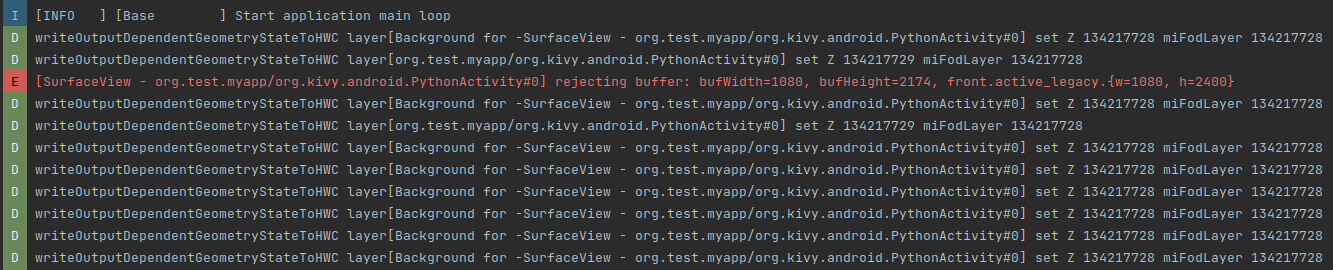

Testamos também o código do repositório do usuário presente na thread https://github.com/opencv/opencv/pull/19597

Link do repositório: https://github.com/Ay-De/Kivy_Python_Camera_Demo

Não obtivemos sucesso <br> Também criamos outras versões de teste, uma delas copiando a lógica de canvas com ask_update presente no repositório citado acima

In [ ]:
#widget Image retirado do build
def build(self):

        self.previewHeight = 1280
        self.previewWidth = 940
        self.texture = Texture.create(size=(self.previewWidth, self.previewHeight), colorfmt='rgb')
        sm = ScreenManager()
        self.main_screen = MainScreen(name="main")
        self.screen_after = ScreenAfterButton(name="after")
        sm.add_widget(self.main_screen)
        sm.add_widget(self.screen_after)
        self.capture = cv2.VideoCapture(0, cv2.CAP_ANDROID)
        if not self.capture.isOpened():
            self.capture.open(0, cv2.CAP_ANDROID)
        self.capture.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc('R', 'G', 'B', '3'))
        self.capture.set(cv2.CAP_PROP_FPS, 30)
        self.capture.set(cv2.CAP_PROP_BUFFERSIZE, 3)
        Clock.schedule_interval(self.load_video, 1 / 30)

        return sm

In [ ]:
def load_video(self, *args):
        ret, frame = self.capture.read()
        if ret:
            self.image_frame = frame
            self.image_frame = cv2.rotate(self.image_frame, cv2.ROTATE_90_CLOCKWISE)
            self.image_frame = cv2.flip(self.image_frame, 0)
            buffer = cv2.flip(frame, 0).tostring()
            self.previewImage = cv2.resize(self.image_frame, dsize=(self.previewWidth, self.previewHeight), interpolation=cv2.INTER_NEAREST)
            self.texture.blit_buffer(self.previewImage.tostring(), colorfmt='rgb', bufferfmt='ubyte')
            self.main_screen.canvas.ask_update() #ao invés do widget image temos o canvas e a função ask_update para atualizar a textura

In [ ]:
<MainScreen>:

    canvas: #canvas adicionado à tela principal
        Color:
            rgba: (255/255, 255/255, 255/255, 255/255)
        Rectangle:
            size: self.size
            pos: self.pos
            texture: app.texture #textura a ser atualizada, no app sendo o self.texture modificaod pelo load_video()

Também testamos o código dado como solução em https://stackoverflow.com/questions/61122285/kivy-camera-application-with-opencv-in-android-shows-black-screen e uma adaptação do código de https://github.com/liyuanrui/kivy-for-android-opencv-demo

O mesmo erro persistiu <br>
Aqui vai algumas observações: <br>
  Utilizamos o open cv 4.7.0 por ser uma versão já dentro das mencionadas com suporte à câmera no android <br>
  Rodei o buildozer em um venv próprio e em um server do colab para ver se estava ocorrendo algum conflito, nada diferente <br>
  Toda vez que rodava o buildozer pelo arquivo master.zip ou stable.zip do kivy para forçar a versão mais recente, obtínhamos erro. Também obtínhamos erro ao pedir uma versão mais recente do kivy.



> 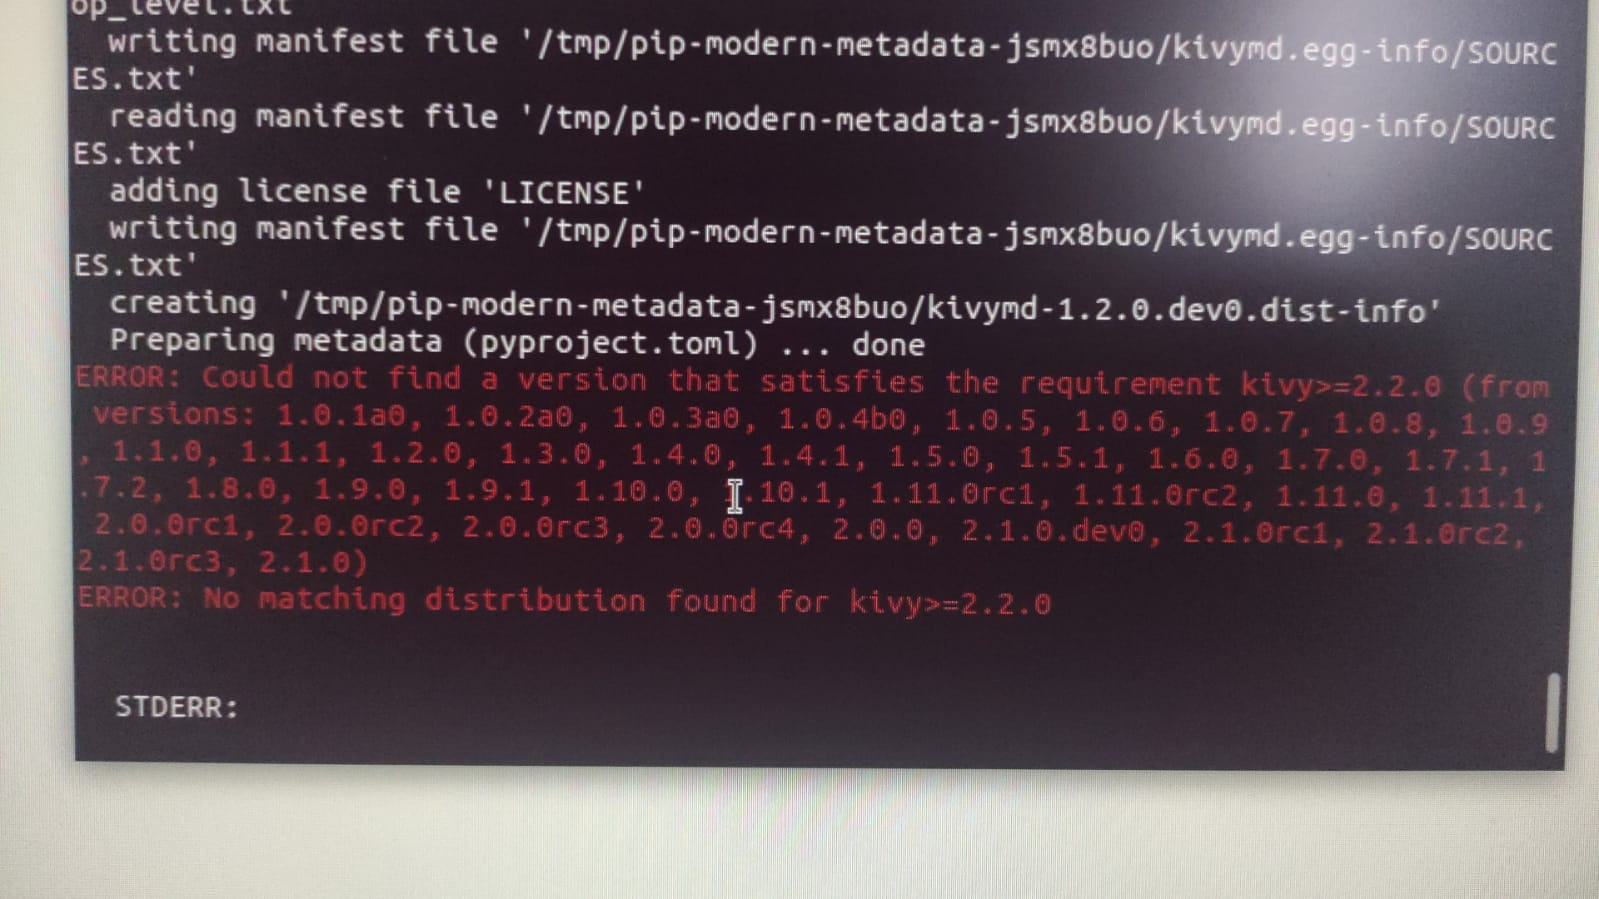



<h4> Em caso de teste <h4/>



Atenção a erros que podem passar desapercebidos ao executar o buildozer: <br>
  Permissões duplicadas, bibliotecas com versões não suportadas (a exemplo tentamos usar kivymd e precisamos dar downgrade na versão pela ausência do kivy 2.2.0), falta de especificação de bibliotecas ou formatos de arquivos suportados

<h1> Conclusão <h1/>

Em decorrência ao erro encontrado e não solucionado em um tempo considerado ágil para o programa, optamos pela opção apresentada e já funcional do protótipo com Flutter